In [7]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import shap


In [9]:
# Print ML Model Results
def ml_model_results(model, X_test, y_test):
    y_pred = model.predict(X_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    model_classification_report = classification_report(y_test, y_pred)
    model_confusion_matrix = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {model_accuracy:.4f}")
    print("Classification Report:")
    print(model_classification_report)
    print("Confusion Matrix:")
    print(model_confusion_matrix)
    del y_pred
    return model_accuracy, model_classification_report, model_confusion_matrix

In [10]:
# Set the path to the dataset
datasetspath = "/Users/saransathy/WalshDBA/Capstone"

In [11]:
# Read Data
mv_dataset3 = pd.read_pickle(f"{datasetspath}/battery_dataset3_normalised.pkl")
etron_df = pd.read_pickle(f"{datasetspath}/Charge_normalised.pkl")

In [12]:
mv_dataset3.sample()

,label,mileage,capacity,car,charge_segment,Curr,SoC,Temp,Volt,MaxVolt,MinVolt,MinTemp
13169438,10,95169.888,0.0,515,128,-0.160762,0.741154,0.55942,-1.846852,-2.685175,-1.82428,-2.178809


In [13]:
# For Modelling purpose the Battery Dataset from 3rd Manufacturer will be used along with
# Audi eTron Data. Need to update Audi eTron data with Charge Segment and Capacity and assume 
# the battery is healthy
# Get unique dates in index in order
unique_dates = pd.Series(etron_df.index.date).drop_duplicates().reset_index(drop=True)

# Map each unique date to its CS value (starting at 0)
cs_map = {date: idx for idx, date in enumerate(unique_dates)}

# Assign CS column based on mapping
etron_df['charge_segment'] = [cs_map[d] for d in etron_df.index.date]
etron_df['car'] = np.max(mv_dataset3['car'])+100
etron_df['mileage'] = 0
etron_df['capacity'] = 95
etron_df['label'] = '00'

# Release Memory
del unique_dates

In [14]:
etron_df.sample()

,Curr,Volt,SoC,Temp,charge_segment,car,mileage,capacity,label
2019-12-21 19:57:00,0.297626,0.163082,0.240911,-1.141365,4,649,0,95,00


In [15]:
cols1 = ['mileage', 'capacity','Curr','SoC','Temp','Volt']
cols2 = ['Curr','SoC','Temp','Volt']
cols3 = ['mileage', 'capacity','Curr','SoC','Temp','Volt', 'Curr_lag','SoC_lag','Temp_lag','Volt_lag']
cols4 = ['Curr','SoC','Temp','Volt', 'Curr_lag','SoC_lag','Temp_lag','Volt_lag']

In [16]:
def ml_prepare_data(df):
    X = df
    lagcols = [col + "_lag" for col in cols2]
    X[lagcols] = df[cols2].shift(1).fillna(0)
    X['label'] = (df['label'] == '10').astype(int)  # Convert to binary labels
    return (X)

In [17]:
df_lag = ml_prepare_data(mv_dataset3)

In [18]:
df_lag.sample()

,label,mileage,capacity,car,charge_segment,Curr,SoC,Temp,Volt,MaxVolt,MinVolt,MinTemp,Curr_lag,SoC_lag,Temp_lag,Volt_lag
10739415,1,103230.336,0.0,510,698,0.544361,0.63916,0.55942,1.008986,0.931489,1.098456,0.793883,0.544361,0.63916,0.55942,1.011276


In [19]:
# Prepare X and y
X, y = df_lag.drop('label',axis=1), df_lag['label']

In [20]:
# Split Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X[cols3], y, test_size=0.4, random_state=42, stratify=y)

In [21]:
X.shape, y.shape, X_train.shape

((22569856, 15), (22569856,), (13541913, 10))

In [22]:
# Fit logistic regression
lrmodel = LogisticRegression()
lrmodel.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [23]:
lracc,lrcr,lrcm = ml_model_results(lrmodel, X_test,y_test)

Accuracy: 0.7347
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68   3956531
           1       0.74      0.80      0.77   5071412

    accuracy                           0.73   9027943
   macro avg       0.73      0.73      0.73   9027943
weighted avg       0.73      0.73      0.73   9027943

Confusion Matrix:
[[2562171 1394360]
 [1000317 4071095]]


In [24]:
print(pd.Series(lrmodel.coef_[0], index=X_train.columns).abs().sort_values(ascending=False))

SoC_lag     0.251472
SoC         0.251394
Volt        0.172356
Volt_lag    0.172222
Temp_lag    0.114038
Temp        0.113933
Curr_lag    0.104088
Curr        0.103233
capacity    0.027101
mileage     0.000022
dtype: float64


LinearExplainer explainer: 9027944it [00:23, 204651.48it/s]                         


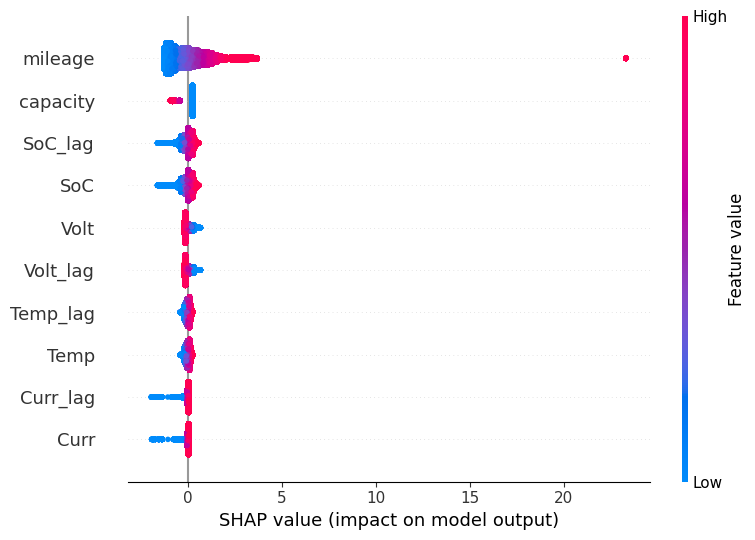

In [25]:
explainer = shap.Explainer(lrmodel, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [26]:
lrmodel.coef_

array([[ 2.22120291e-05, -2.71010051e-02,  1.03232511e-01,
         2.51394487e-01,  1.13933366e-01, -1.72355739e-01,
         1.04087834e-01,  2.51471789e-01,  1.14037985e-01,
        -1.72221651e-01]])

In [33]:
X_train[cols3]

,mileage,capacity,Curr,SoC,Temp,Volt,Curr_lag,SoC_lag,Temp_lag,Volt_lag
5159154,176266.464,0.000000,-0.160762,0.741154,0.664479,-1.017812,-0.160762,0.741154,0.664479,-1.017812
16136250,51503.232,40.013382,0.544361,0.843148,0.769537,1.143534,0.544361,0.843148,0.769537,1.142961
2634373,56229.888,0.000000,-0.243717,0.945142,1.294831,-1.759826,-0.243717,0.945142,1.294831,-1.764406
20233044,12003.552,0.000000,0.521250,0.055612,-0.175991,1.111520,0.521261,0.055599,-0.175991,1.111522
5928704,54017.568,36.973987,0.254016,-1.706697,-1.751871,-1.402560,0.254016,-1.706697,-1.751871,-1.402560
...,...,...,...,...,...,...,...,...,...,...
9794473,45334.080,0.000000,-0.160762,-0.686759,-0.911402,0.173075,-0.160762,-0.686759,-0.911402,0.173075
12380173,40114.272,32.813707,0.544361,-0.380778,-0.386108,0.942571,0.544361,-0.380778,-0.386108,0.947152
17157250,107219.904,37.812345,-0.119284,0.843148,0.874596,0.333387,-0.119284,0.843148,0.874596,0.333387
20707856,89.760,0.000000,0.544361,-1.502710,-1.751871,-1.846852,0.544361,-1.502710,-1.751871,-1.846852


In [34]:
# Try tuning further with eTron data
# Prepare etron data
etron_lag = ml_prepare_data(etron_df)
X = pd.concat([X_train[cols3], etron_lag[cols3]], axis=0, ignore_index=True)
y = pd.concat([y_train, etron_lag['label']], axis=0, ignore_index=True)

In [35]:
lrmodel_tuned = LogisticRegression(warm_start=True)
lrmodel_tuned.coef_ = lrmodel.coef_.copy()
lrmodel_tuned.intercept_ = lrmodel.intercept_.copy()
lrmodel_tuned.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [36]:
lrtacc,lrtcr,lrtcm = ml_model_results(lrmodel_tuned, X_test,y_test)

Accuracy: 0.7406
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.71   3956531
           1       0.77      0.76      0.77   5071412

    accuracy                           0.74   9027943
   macro avg       0.74      0.74      0.74   9027943
weighted avg       0.74      0.74      0.74   9027943

Confusion Matrix:
[[2815047 1141484]
 [1200691 3870721]]


In [41]:
sgmodel = SGDClassifier(loss="log_loss")
sgmodel.partial_fit(X_train, y_train, classes=np.unique(y_train))

,loss,'log_loss'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [42]:
sgacc,sgcr,sgcm = ml_model_results(sgmodel, X_test,y_test)

Accuracy: 0.5845
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.09      0.16   3956531
           1       0.58      0.97      0.72   5071412

    accuracy                           0.58   9027943
   macro avg       0.63      0.53      0.44   9027943
weighted avg       0.63      0.58      0.48   9027943

Confusion Matrix:
[[ 370037 3586494]
 [ 165034 4906378]]


In [43]:
sgmodel.partial_fit(etron_lag[cols3],etron_lag['label'])

,loss,'log_loss'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [45]:
sgtacc,sgtcr,sgtcm = ml_model_results(sgmodel, X_test,y_test)

Accuracy: 0.5847
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.09      0.17   3956531
           1       0.58      0.97      0.72   5071412

    accuracy                           0.58   9027943
   macro avg       0.64      0.53      0.44   9027943
weighted avg       0.63      0.58      0.48   9027943

Confusion Matrix:
[[ 372569 3583962]
 [ 165098 4906314]]


In [37]:
# Random Forest Classifier
rfmodel = RandomForestClassifier()
rfmodel.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [38]:
rfacc,rfcr,rfcm = ml_model_results(rfmodel, X_test,y_test)

Accuracy: 0.9994
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3956531
           1       1.00      1.00      1.00   5071412

    accuracy                           1.00   9027943
   macro avg       1.00      1.00      1.00   9027943
weighted avg       1.00      1.00      1.00   9027943

Confusion Matrix:
[[3953734    2797]
 [   2580 5068832]]


In [ ]:
explainer = shap.Explainer(rfmodel, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)